<a href="https://colab.research.google.com/github/cristopher-d-delgado/image_classification_pneumonia/blob/main/mlp_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pneumonia Detection on Chest X-Rays

In [1]:
# Import data managing libraries
import numpy as np
import pandas as pd

# Import Tensorflow
import tensorflow as tf
import tensorflow.keras as keras

# Plotting
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import random
# Set the seed for repeatability
seed = 42

# Set random seed for NumPy
np.random.seed(42)

# Set random seed for TensorFlow
tf.random.set_seed(42)

# Set random seed for Python's built-in random module
random.seed(42)

In [2]:
# # Google Drive connection

# from google.colab import drive
# drive.mount('/content/drive/')

# Explore our Data & Preprocess

In [8]:
import os
# Create a path to the root folder and path to specific folders on my computer
# data_path = '/content/drive/MyDrive/Flatiron/phase4/chest_xray/chest_xray'
# data_path = 'data\chest_xray\chest_xray'
data_path = "data/chest_xray/"
#data_path = "data/CellData/chest_xray/"
data_path

# Specificy paths for train, test, val
train_folder = os.path.join(data_path, 'train/')
test_folder = os.path.join(data_path, 'test/')
val_folder = os.path.join(data_path, 'validation/')

# Specify paths for labels
train_normal = os.path.join(train_folder, 'NORMAL')
train_pneumonia = os.path.join(train_folder, 'PNEUMONIA')
test_normal = os.path.join(test_folder, "NORMAL")
test_pneumonia = os.path.join(test_folder, "PNEUMONIA")
val_normal = os.path.join(val_folder, "NORMAL")
val_pneumonia = os.path.join(val_folder, "PNEUMONIA")

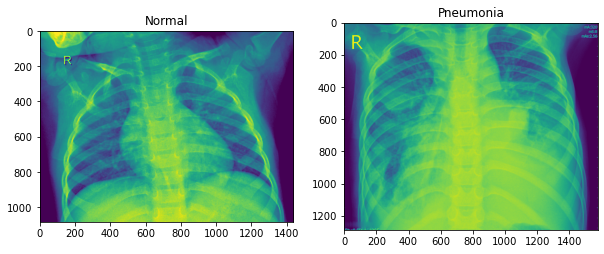

In [6]:
from PIL import Image
import matplotlib.pyplot as plt

# Read images
# img1 = Image.open("/content/drive/MyDrive/Flatiron/phase4/chest_xray/train/NORMAL/IM-0115-0001.jpeg")
# img2 = Image.open("/content/drive/MyDrive/Flatiron/phase4/chest_xray/train/PNEUMONIA/person1000_bacteria_2931.jpeg")
# img1 = Image.open("data/chest_xray/chest_xray/train/NORMAL/IM-0115-0001.jpeg")
# img2 = Image.open("data/chest_xray/chest_xray/train/PNEUMONIA/person1000_bacteria_2931.jpeg")

# img1 = Image.open(r"data\CellData\chest_xray\train\NORMAL\NORMAL-32326-0001.jpeg")
# img2 = Image.open(r"data\CellData\chest_xray\train\PNEUMONIA\BACTERIA-37006-0002.jpeg")


img1 = Image.open(r"data\chest_xray\train\NORMAL\NORMAL-32326-0001.jpeg")
img2 = Image.open(r"data\chest_xray\train\PNEUMONIA\BACTERIA-37006-0002.jpeg")

# Display images side by side
plt.figure(figsize=(10, 5))

# Plot the first image
plt.subplot(1, 2, 1)
plt.imshow(img1)
plt.title('Normal')

# Plot the second image
plt.subplot(1, 2, 2)
plt.imshow(img2)
plt.title('Pneumonia')

plt.show()

It seems that the images are not actually on the same size. Visually we can see the bacterial infection. We would have to preprocess the images to become the same size and also lower the scale since training a neuwral network is resource intensive. Lets explore how many images we have in each directory.

In [9]:
print('There are', len(os.listdir(train_normal)), 'normal images in the training set')
print('There are', len(os.listdir(train_pneumonia)), 'pneumonia images in the training set')
print("________________________________________________________________________________________")
print('There are', len(os.listdir(test_normal)), 'normal images in the testing set')
print('There are', len(os.listdir(test_pneumonia)), 'pneumonia images in the testing set')
print("________________________________________________________________________________________")
print('There are', len(os.listdir(val_normal)), 'normal images in the validation set')
print('There are', len(os.listdir(val_pneumonia)), 'pneumonia images in the validation set')

There are 1215 normal images in the training set
There are 2719 pneumonia images in the training set
________________________________________________________________________________________
There are 235 normal images in the testing set
There are 390 pneumonia images in the testing set
________________________________________________________________________________________
There are 134 normal images in the validation set
There are 1164 pneumonia images in the validation set


Lets preprocess the images by resizing to (256, 256, 3)

In [10]:
from functions import process_data

# Define our data directories
train_data_dir = train_folder
test_data_dir = test_folder
val_data_dir = val_folder

# Preprocess data with our function
train_gen, test_gen, val_gen = process_data(256, 32, train_data_dir, test_data_dir, val_data_dir)

Found 3934 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 1298 images belonging to 2 classes.


It seems the generators are working as expected

Image dimensions: (256, 256, 3)


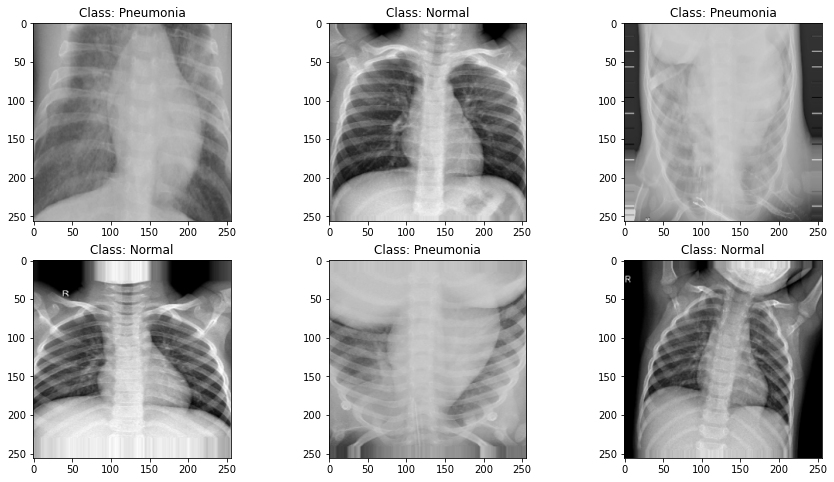

In [11]:
# Retrieve one batch of images from the generator
images, labels = train_gen.next()

# Print the dimensions of the first image
print("Image dimensions:", images[0].shape)

# Display the first six images with their labels
fig, ax = plt.subplots(2, 3, figsize=(15, 8))

ax[0, 0].imshow(images[0])
ax[0, 0].set_title(f"Class: {'Normal' if labels[0] == 0 else 'Pneumonia'}")

ax[0, 1].imshow(images[1])
ax[0, 1].set_title(f"Class: {'Normal' if labels[1] == 0 else 'Pneumonia'}")

ax[0, 2].imshow(images[2])
ax[0, 2].set_title(f"Class: {'Normal' if labels[2] == 0 else 'Pneumonia'}")

ax[1, 0].imshow(images[3])
ax[1, 0].set_title(f"Class: {'Normal' if labels[3] == 0 else 'Pneumonia'}")

ax[1, 1].imshow(images[4])
ax[1, 1].set_title(f"Class: {'Normal' if labels[4] == 0 else 'Pneumonia'}")

ax[1, 2].imshow(images[5])
ax[1, 2].set_title(f"Class: {'Normal' if labels[5] == 0 else 'Pneumonia'}")

plt.show()


We sucecssfully resized the images and also created an RGB tensor. Lets create our datasets

# Make an Multilayer Perceptrons Model

I don't expect great perfomance in comparison to a Convuluted Neural Network. For the sake of trying we should attempt a basic neural network before getting more complex using basic MLP layers

**Base MLP Model:**

Define Base Model

We can attempt to train the model by iterating over the numebr of epochs. We can then save look at the validation and training loss and see where it begins to overfit.

In [13]:
from tensorflow.keras.metrics import Precision, Recall

# Define metrics we want to log
METRICS = metrics=[
        Precision(name='precision'),
        Recall(name='recall'),
        'accuracy'
    ]

In [33]:
import time
import pandas as pd
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam


# Define input shape
input_shape = (256, 256, 3)

# Define the basic model 
model_mlp_base = Sequential()

# Define the layers 
model_mlp_base.add(Flatten(input_shape=input_shape))
model_mlp_base.add(Dense(64, activation='relu', input_shape=input_shape))
model_mlp_base.add(Dense(1, activation='sigmoid'))
model_mlp_base.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=METRICS)
print(model_mlp_base.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 196608)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                12582976  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 12,583,041
Trainable params: 12,583,041
Non-trainable params: 0
_________________________________________________________________
None


In [34]:
from functions import train_model

mlp = {}
mlp['Version1'] = train_model(model_mlp_base, train_gen, val_gen, total_epochs=30)

Epoch 1/30
  1/123 [..............................] - ETA: 0s - loss: 0.7236 - precision: 0.5938 - recall: 1.0000 - accuracy: 0.5938WARNING:tensorflow:From c:\Users\delga\anaconda3\envs\flatiron2\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
123/123 [==============================] - 107s 871ms/step - loss: 3.0665 - precision: 0.7732 - recall: 0.7885 - accuracy: 0.6940 - val_loss: 0.1682 - val_precision: 0.9441 - val_recall: 0.9863 - val_accuracy: 0.9353
Epoch 2/30
123/123 [==============================] - 65s 531ms/step - loss: 0.7385 - precision: 0.8285 - recall: 0.8474 - accuracy: 0.7733 - val_loss: 2.9560 - val_precision: 1.0000 - val_recall: 0.2088 - val_accuracy: 0.2904
Epoch 3/30
123/123 [==============================] - 66s 533ms/step - loss: 1.0094 - precision: 0.8218 - recall: 0.8194 - accu

In [35]:
print(mlp['Version1'].keys())

dict_keys(['loss', 'precision', 'recall', 'accuracy', 'val_loss', 'val_precision', 'val_recall', 'val_accuracy'])


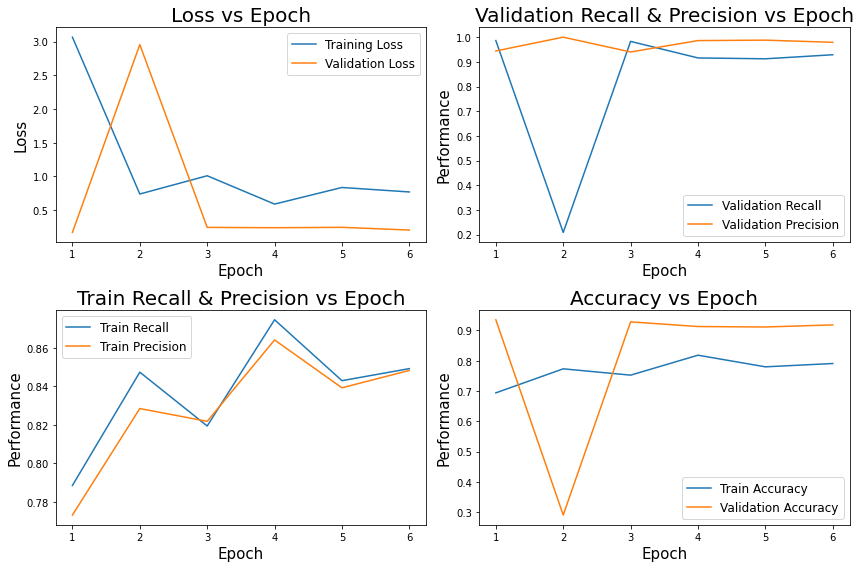

In [36]:
from functions import view_history

view_history(model_mlp_base, 'Version1')

In [139]:
from functions import model_evaluate

model_evaluate(model_mlp_base, train_gen, test_gen, val_gen)

1/1 [==============================] - 0s 998us/step - loss: 1.1881 - precision: 0.5714 - recall: 1.0000 - accuracy: 0.6250


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.407033,84.300643,97.832257,84.854293
1,Test,0.538780,76.767677,97.435898,79.967946
2,Validation,1.188068,57.142860,100.000000,62.500000


We can tell we are underfitting as our validation loss seems to flatline with our traing loss. Our losses were decreasing and then flatlined suggesting that our model may not be complex enough to learn the data correctly. Lets add more neurons and one layer 

# MLP Version 2

In [10]:
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam

# Define input shape
input_shape = (256, 256, 3)

# Define the basic model 
model_mlp_base_2 = Sequential()

# Define the layers 
# Flatten the input layer for the Dense layers
model_mlp_base_2.add(Flatten(input_shape=input_shape))

# Define our Dense Layers
model_mlp_base_2.add(Dense(128, activation='relu'))
model_mlp_base_2.add(Dense(64, activation='relu'))

# Define output layer
model_mlp_base_2.add(Dense(1, activation='sigmoid'))

# Compile the model
model_mlp_base_2.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=METRICS)
print(model_mlp_base_2.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 196608)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               25165952  
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 25,174,273
Trainable params: 25,174,273
Non-trainable params: 0
_________________________________________________________________
None


In [11]:
from functions import train_model
# Update our dictionary with Version 2
mlp = {}

mlp['Version2'] = train_model(model_mlp_base_2, train_gen, val_gen, total_epochs=30)

Epoch 1/30
  1/123 [..............................] - ETA: 0s - loss: 0.7757 - precision: 0.0000e+00 - recall: 0.0000e+00 - accuracy: 0.4062WARNING:tensorflow:From c:\Users\delga\anaconda3\envs\flatiron2\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
123/123 [==============================] - 70s 573ms/step - loss: 4.1874 - precision: 0.7737 - recall: 0.7757 - accuracy: 0.6881 - val_loss: 0.5198 - val_precision: 0.9914 - val_recall: 0.7964 - val_accuracy: 0.8112
Epoch 2/30
123/123 [==============================] - 69s 565ms/step - loss: 0.5549 - precision: 0.8342 - recall: 0.8588 - accuracy: 0.7844 - val_loss: 1.0041 - val_precision: 0.9982 - val_recall: 0.4656 - val_accuracy: 0.5200
Epoch 3/30
123/123 [==============================] - 69s 563ms/step - loss: 0.7623 - precision: 0.8148 - recall: 0.8286

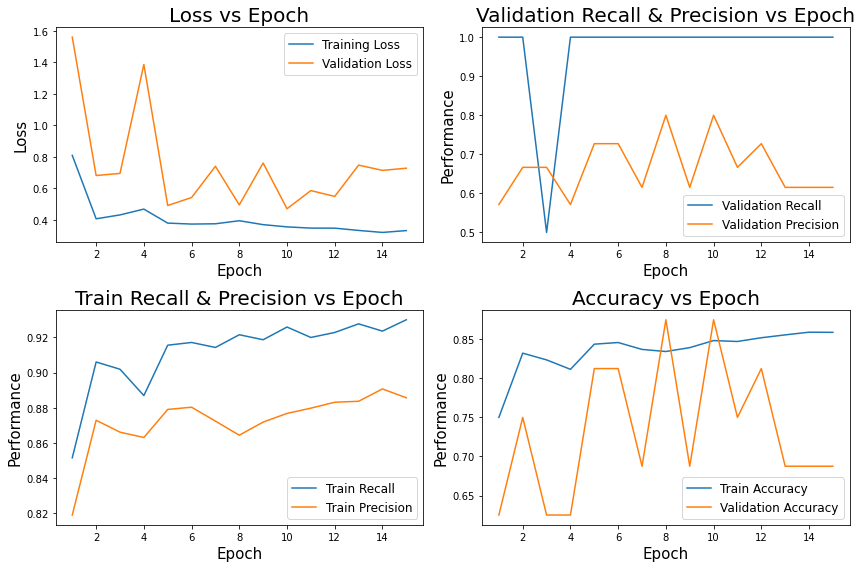

In [ ]:
from functions import view_history
# Visualize the history 

view_history(mlp, 'Version2')

In [ ]:
from functions import model_evaluate
# Evaluate the model

model_evaluate(model_mlp_base_2, train_gen, test_gen, val_gen)

1/1 [==============================] - 0s 994us/step - loss: 0.7274 - precision: 0.6154 - recall: 1.0000 - accuracy: 0.6875


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.312938,86.000454,97.496772,86.349696
1,Test,0.400868,79.741377,94.871795,81.730771
2,Validation,0.727367,61.538464,100.000000,68.750000


It seems that adding another layer helped generalize more. It generally does follow closely up until epoch 12 where the validation loss increases while train loss decreases suggesting overfit. We can attempt to add some regularization to the layers.

# MLP Version 3

In [12]:
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define input shape
input_shape = (256, 256, 3)

# Define the basic model 
model_mlp_base_3 = Sequential()

# Define the layers 
# Flatten the input layer for the Dense layers
model_mlp_base_3.add(Flatten(input_shape=input_shape))

# Define our Dense Layers
model_mlp_base_3.add(Dense(128, activation='relu'))
model_mlp_base_3.add(Dropout(.2))
model_mlp_base_3.add(Dense(64, activation='relu'))
model_mlp_base_3.add(Dropout(.2))

# Define output layer
model_mlp_base_3.add(Dense(1, activation='sigmoid'))

# Compile the model
model_mlp_base_3.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=METRICS)
print(model_mlp_base_3.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 196608)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               25165952  
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 25,174,273
Trainable params: 25,174,273
Non-trainable params: 0
__________________________________________

In [13]:
# Update our dictionary with Version 3
mlp['Version3'] = train_model(model_mlp_base_3, train_gen, val_gen, total_epochs=30)

Epoch 1/30
123/123 [==============================] - 71s 580ms/step - loss: 4.4665 - precision: 0.7783 - recall: 0.8027 - accuracy: 0.6027 - val_loss: 0.6733 - val_precision: 0.8968 - val_recall: 1.0000 - val_accuracy: 0.8968
Epoch 2/30
123/123 [==============================] - 69s 565ms/step - loss: 0.6742 - precision: 0.6912 - recall: 1.0000 - accuracy: 0.6912 - val_loss: 0.6324 - val_precision: 0.8968 - val_recall: 1.0000 - val_accuracy: 0.8968
Epoch 3/30
123/123 [==============================] - 69s 563ms/step - loss: 0.6587 - precision: 0.6912 - recall: 1.0000 - accuracy: 0.6912 - val_loss: 0.5994 - val_precision: 0.8968 - val_recall: 1.0000 - val_accuracy: 0.8968
Epoch 4/30
123/123 [==============================] - 69s 564ms/step - loss: 0.6472 - precision: 0.6912 - recall: 1.0000 - accuracy: 0.6912 - val_loss: 0.5721 - val_precision: 0.8968 - val_recall: 1.0000 - val_accuracy: 0.8968
Epoch 5/30
123/123 [==============================] - 70s 571ms/step - loss: 0.6387 - precis

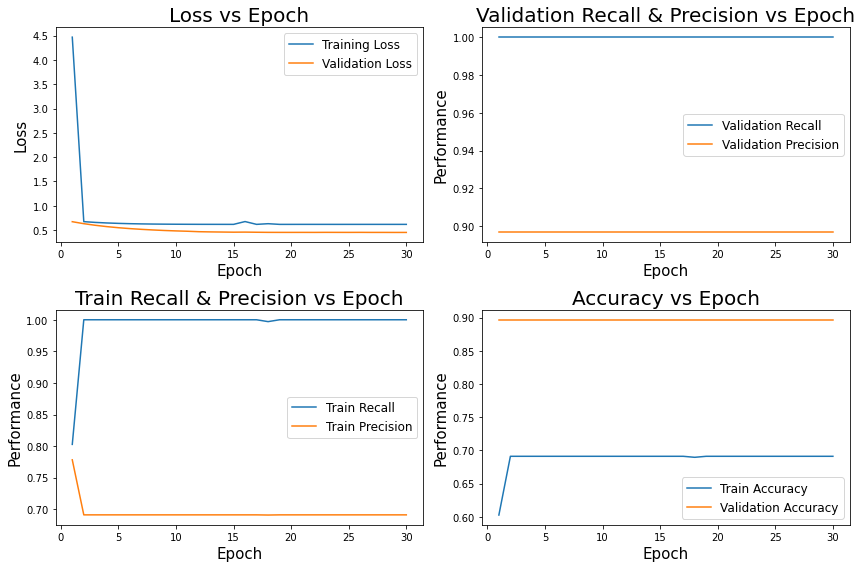

In [15]:
# Visualize the history 
from functions import view_history
view_history(mlp, 'Version3')

In [ ]:
# Evaluate the model
from functions import model_evaluate
model_evaluate(model_mlp_base_3, train_gen, test_gen, val_gen)

1/1 [==============================] - 0s 1ms/step - loss: 1.5010 - precision: 0.5333 - recall: 1.0000 - accuracy: 0.5625


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.736106,75.170004,99.845159,75.383437
1,Test,0.982785,62.700963,100.000000,62.820512
2,Validation,1.500984,53.333336,100.000000,56.250000


This is interesting. Its clear that we added too much regularization. We can try to get rid of one of them and see the results. If not we can add more layers with dropout since the models needs more information to properly predict 

# MLP Version 4

In [16]:
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define input shape
input_shape = (256, 256, 3)

# Define the basic model 
model_mlp_base_4 = Sequential()

# Define the layers 
# Flatten the input layer for the Dense layers
model_mlp_base_4.add(Flatten(input_shape=input_shape))

# Define our Dense Layers
model_mlp_base_4.add(Dense(128, activation='relu'))
model_mlp_base_4.add(Dropout(.2))
model_mlp_base_4.add(Dense(64, activation='relu'))

# Define output layer
model_mlp_base_4.add(Dense(1, activation='sigmoid'))

# Compile the model
model_mlp_base_4.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=METRICS)
print(model_mlp_base_4.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 196608)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               25165952  
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 25,174,273
Trainable params: 25,174,273
Non-trainable params: 0
_________________________________________________________________
None


In [17]:
# Update our dictionary with Version 4
mlp['Version4'] = train_model(model_mlp_base_4, train_gen, val_gen, total_epochs=30)

Epoch 1/30
123/123 [==============================] - 72s 588ms/step - loss: 6.8214 - precision: 0.7765 - recall: 0.8287 - accuracy: 0.6296 - val_loss: 0.6662 - val_precision: 0.9183 - val_recall: 0.7534 - val_accuracy: 0.7188
Epoch 2/30
123/123 [==============================] - 71s 575ms/step - loss: 0.5775 - precision: 0.7693 - recall: 0.8352 - accuracy: 0.7130 - val_loss: 0.4029 - val_precision: 0.9873 - val_recall: 0.8668 - val_accuracy: 0.8706
Epoch 3/30
123/123 [==============================] - 69s 564ms/step - loss: 0.5431 - precision: 0.7697 - recall: 0.8959 - accuracy: 0.7428 - val_loss: 0.2727 - val_precision: 0.9016 - val_recall: 0.9991 - val_accuracy: 0.9014
Epoch 4/30
123/123 [==============================] - 71s 575ms/step - loss: 0.6456 - precision: 0.7645 - recall: 0.9095 - accuracy: 0.7438 - val_loss: 0.3277 - val_precision: 0.9884 - val_recall: 0.8771 - val_accuracy: 0.8806
Epoch 5/30
123/123 [==============================] - 70s 566ms/step - loss: 0.4712 - precis

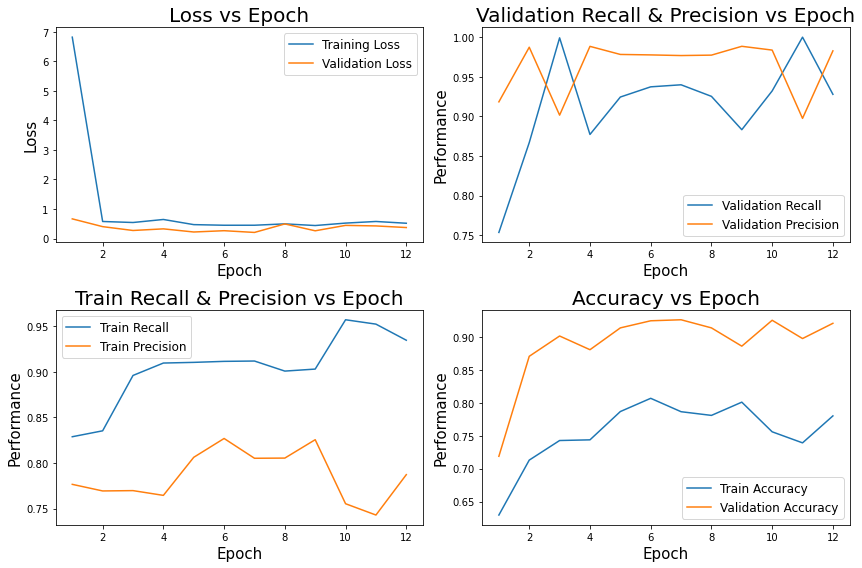

In [18]:
# Visualize the history 
from functions import view_history
view_history(mlp, 'Version4')

In [19]:
# Evaluate the model
from functions import model_evaluate
model_evaluate(model_mlp_base_4, train_gen, test_gen, val_gen)

41/41 [==============================] - 7s 176ms/step - loss: 0.3723 - precision: 0.9827 - recall: 0.9278 - accuracy: 0.9206


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.439527,84.951615,93.637365,84.138280
1,Test,0.439591,86.764705,90.769231,85.576922
2,Validation,0.372287,98.271155,92.783505,92.064714


Now it seems better but our validation data performs better than the train data. That is probably because our validation data may be easier to predict than the training. Lets attemept to use a smaller dropout

# MLP Version 5

In [20]:
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define input shape
input_shape = (256, 256, 3)

# Define the basic model 
model_mlp_base_5 = Sequential()

# Define the layers 
# Flatten the input layer for the Dense layers
model_mlp_base_5.add(Flatten(input_shape=input_shape))

# Define our Dense Layers
model_mlp_base_5.add(Dense(128, activation='relu'))
model_mlp_base_5.add(Dropout(.05))
model_mlp_base_5.add(Dense(64, activation='relu'))

# Define output layer
model_mlp_base_5.add(Dense(1, activation='sigmoid'))

# Compile the model
model_mlp_base_5.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=METRICS)
print(model_mlp_base_5.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 196608)            0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               25165952  
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 25,174,273
Trainable params: 25,174,273
Non-trainable params: 0
_________________________________________________________________
None


In [21]:
mlp['Version5'] = train_model(model_mlp_base_5, train_gen, val_gen, total_epochs=30)

Epoch 1/30
123/123 [==============================] - 76s 616ms/step - loss: 4.9725 - precision: 0.8156 - recall: 0.8032 - accuracy: 0.6528 - val_loss: 0.1707 - val_precision: 0.9463 - val_recall: 0.9837 - val_accuracy: 0.9353
Epoch 2/30
123/123 [==============================] - 74s 599ms/step - loss: 0.7038 - precision: 0.8085 - recall: 0.8415 - accuracy: 0.7527 - val_loss: 0.4397 - val_precision: 0.9955 - val_recall: 0.7629 - val_accuracy: 0.7843
Epoch 3/30
123/123 [==============================] - 75s 607ms/step - loss: 0.5875 - precision: 0.8295 - recall: 0.8768 - accuracy: 0.7903 - val_loss: 0.5130 - val_precision: 0.9942 - val_recall: 0.7311 - val_accuracy: 0.7550
Epoch 4/30
123/123 [==============================] - 70s 572ms/step - loss: 0.5751 - precision: 0.8186 - recall: 0.8566 - accuracy: 0.7697 - val_loss: 0.1411 - val_precision: 0.9571 - val_recall: 0.9785 - val_accuracy: 0.9414
Epoch 5/30
123/123 [==============================] - 70s 566ms/step - loss: 0.5172 - precis

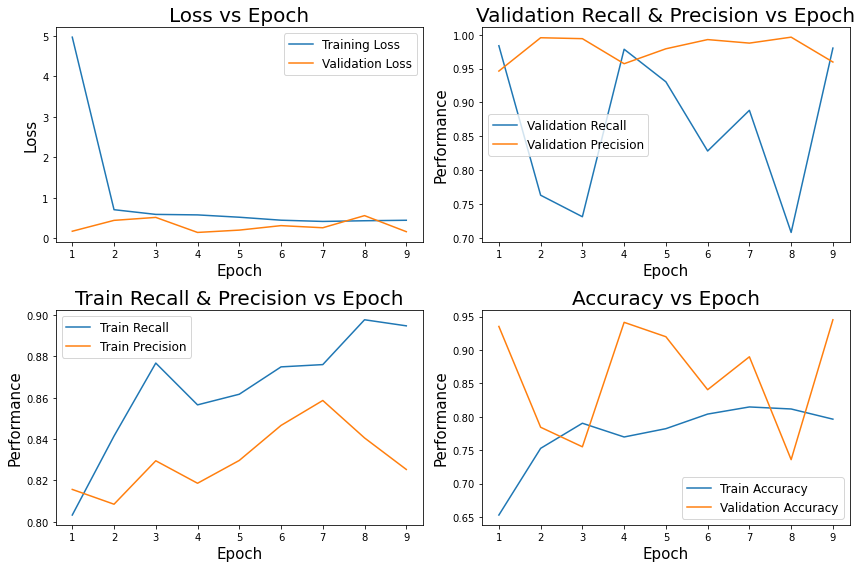

In [22]:
view_history(mlp, "Version5")

In [23]:
model_evaluate(model_mlp_base_5, train_gen, test_gen, val_gen)

41/41 [==============================] - 7s 174ms/step - loss: 0.1598 - precision: 0.9596 - recall: 0.9802 - accuracy: 0.9453


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.413305,80.054480,97.278410,81.367564
1,Test,0.473769,75.595236,97.692305,78.846157
2,Validation,0.159841,95.962995,98.024052,94.530046


We seem to be generalizing better but its possible that maybe we just do not have enough captured information to generalize. Lets add layers with dropout just to see what happens

# MLP Version 6

In [24]:
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from functions import get_optimizer

# Define input shape
input_shape = (256, 256, 3)

# Define the basic model 
model_mlp_base_6 = Sequential()

# Define the layers 
# Flatten the input layer for the Dense layers
model_mlp_base_6.add(Flatten(input_shape=input_shape))

# Define our Dense Layers with Droput and Regularizer
model_mlp_base_6.add(Dense(128, activation='relu', kernel_regularizer=l2()))
model_mlp_base_6.add(Dropout(.2))
model_mlp_base_6.add(Dense(64, activation='relu', kernel_regularizer=l2()))
model_mlp_base_6.add(Dropout(.2))
model_mlp_base_6.add(Dense(64, activation='relu', kernel_regularizer=l2()))
model_mlp_base_6.add(Dropout(.2))
model_mlp_base_6.add(Dense(16, activation='relu', kernel_regularizer=l2()))
model_mlp_base_6.add(Dropout(.2))

# Define output layer
model_mlp_base_6.add(Dense(1, activation='sigmoid'))

# Compile the model
model_mlp_base_6.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=METRICS)
print(model_mlp_base_6.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 196608)            0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               25165952  
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)               

In [25]:
mlp['Version6'] = train_model(model_mlp_base_6, train_gen, val_gen, total_epochs=30)

Epoch 1/30
123/123 [==============================] - 81s 659ms/step - loss: 6.4671 - precision: 0.7683 - recall: 0.8009 - accuracy: 0.5831 - val_loss: 2.3780 - val_precision: 0.8968 - val_recall: 1.0000 - val_accuracy: 0.8968
Epoch 2/30
123/123 [==============================] - 80s 650ms/step - loss: 2.1376 - precision: 0.6879 - recall: 0.9121 - accuracy: 0.6533 - val_loss: 1.9442 - val_precision: 0.8968 - val_recall: 1.0000 - val_accuracy: 0.8968
Epoch 3/30
123/123 [==============================] - 78s 632ms/step - loss: 1.8539 - precision: 0.6918 - recall: 0.9743 - accuracy: 0.6823 - val_loss: 1.8027 - val_precision: 0.8968 - val_recall: 1.0000 - val_accuracy: 0.8968
Epoch 4/30
123/123 [==============================] - 78s 637ms/step - loss: 1.7902 - precision: 0.6893 - recall: 0.9750 - accuracy: 0.6790 - val_loss: 1.6683 - val_precision: 0.8968 - val_recall: 1.0000 - val_accuracy: 0.8968
Epoch 5/30
123/123 [==============================] - 78s 633ms/step - loss: 1.6548 - precis

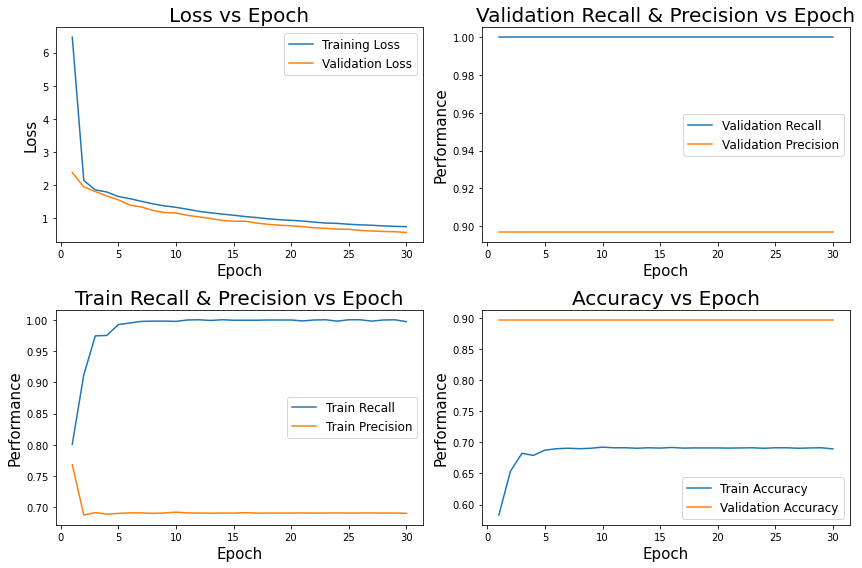

In [26]:
from  functions import view_history
view_history(mlp, "Version6")

In [27]:
from functions import model_evaluate

model_evaluate(model_mlp_base_6, train_gen, test_gen, val_gen)

41/41 [==============================] - 8s 193ms/step - loss: 0.5688 - precision: 0.8968 - recall: 1.0000 - accuracy: 0.8968


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.730799,69.115406,100.0,69.115406
1,Test,0.782922,62.500000,100.0,62.500000
2,Validation,0.568839,89.676428,100.0,89.676428


We did really well but we need to make the model more complex to avoid getting perfect recall for a test set. It doesnt seem like we overfitted yet so we can add more layers and more regularizers. 

# MLP Version 7

In [28]:
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from functions import get_optimizer

# Define input shape
input_shape = (256, 256, 3)

# Define the basic model 
model_mlp_base_7 = Sequential()

# Define the layers 
# Flatten the input layer for the Dense layers
model_mlp_base_7.add(Flatten(input_shape=input_shape))

# Define our Dense Layers with Droput and Regularizer
model_mlp_base_7.add(Dense(128, activation='relu'))
model_mlp_base_7.add(Dropout(.05))
model_mlp_base_7.add(Dense(64, activation='relu'))
model_mlp_base_7.add(Dropout(.05))
model_mlp_base_7.add(Dense(64, activation='relu'))
model_mlp_base_7.add(Dropout(.05))

# Define output layer
model_mlp_base_7.add(Dense(1, activation='sigmoid'))

# Compile the model
model_mlp_base_7.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=METRICS)
print(model_mlp_base_7.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 196608)            0         
_________________________________________________________________
dense_17 (Dense)             (None, 128)               25165952  
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_10 (Dropout)         (None, 64)               

In [29]:
mlp['Version7'] = train_model(model_mlp_base_7, train_gen, val_gen, total_epochs=30)

Epoch 1/30
123/123 [==============================] - 72s 582ms/step - loss: 4.4025 - precision: 0.7755 - recall: 0.8120 - accuracy: 0.6164 - val_loss: 1.0875 - val_precision: 0.9939 - val_recall: 0.4218 - val_accuracy: 0.4792
Epoch 2/30
123/123 [==============================] - 69s 563ms/step - loss: 0.7038 - precision: 0.7109 - recall: 0.9143 - accuracy: 0.6838 - val_loss: 0.5757 - val_precision: 0.8968 - val_recall: 1.0000 - val_accuracy: 0.8968
Epoch 3/30
123/123 [==============================] - 69s 564ms/step - loss: 0.7003 - precision: 0.6912 - recall: 1.0000 - accuracy: 0.6912 - val_loss: 0.4758 - val_precision: 0.8968 - val_recall: 1.0000 - val_accuracy: 0.8968
Epoch 4/30
123/123 [==============================] - 69s 564ms/step - loss: 0.6556 - precision: 0.6916 - recall: 0.9930 - accuracy: 0.6891 - val_loss: 0.4564 - val_precision: 0.8968 - val_recall: 1.0000 - val_accuracy: 0.8968
Epoch 5/30
123/123 [==============================] - 70s 568ms/step - loss: 0.6186 - precis

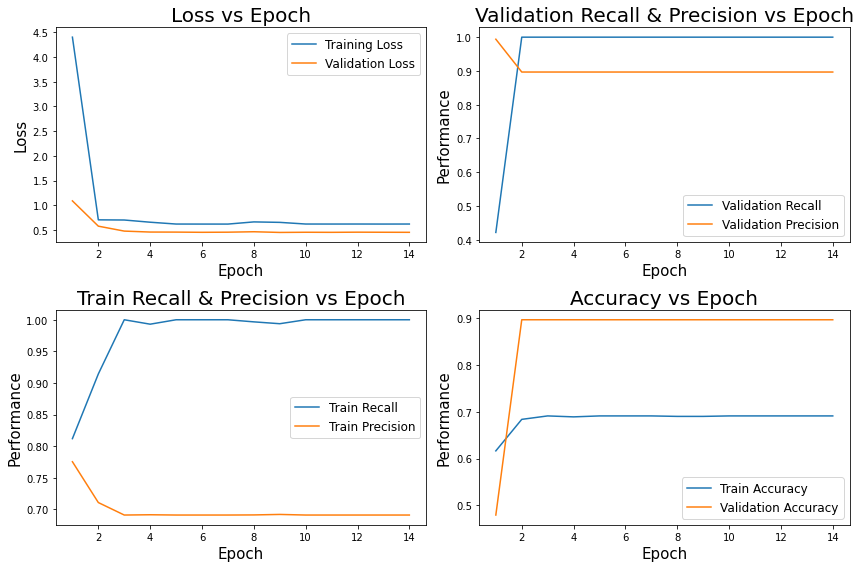

In [31]:
from functions import view_history
view_history(mlp, "Version7")

In [32]:
from functions import model_evaluate
model_evaluate(model_mlp_base_7, train_gen, test_gen, val_gen)

41/41 [==============================] - 7s 177ms/step - loss: 0.4510 - precision: 0.8968 - recall: 1.0000 - accuracy: 0.8968


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.618180,69.115406,100.0,69.115406
1,Test,0.672801,62.500000,100.0,62.500000
2,Validation,0.451030,89.676428,100.0,89.676428


It seems regardless of adding more reguilarization and layers we don't perform better. We actually just overfitted completely. We are bettter off using version 5. We can try to make the set performances better by introducing more data augmentation and CNN. Right now the current image data gen just normalizes and zooms in. We can try doing more to it. Lets move to Convolutional Neural Networks. The results so far for recall make sense because we have an imblance set. 

# Convolutional Neural Network


Based off our work from the MLP section Version 6 was our best model performance for loss and not overfitting. Lets use that layout and add Convolutional Layers to it

In [14]:
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam

# Define input shape
input_shape = (256, 256, 3)

# Define the basic model 
cnn_1 = Sequential()

# Define the layers
# Define our Conv layer
cnn_1.add(Conv2D(32, (3,3), 1, activation='relu', input_shape=input_shape))
cnn_1.add(MaxPool2D())

# Flatten the input layer for the Dense layers
cnn_1.add(Flatten())

# Define our Dense Layers
cnn_1.add(Dense(128, activation='relu'))
cnn_1.add(Dropout(.2))
cnn_1.add(Dense(64, activation='relu'))

# Define output layer
cnn_1.add(Dense(1, activation='sigmoid'))

# Compile the model
cnn_1.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=METRICS)
print(cnn_1.summary())


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 516128)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               66064512  
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [15]:
from functions import train_model

cnn = {}

cnn['Version1'] = train_model(cnn_1, train_gen, val_gen, 40)

Epoch 1/40
  1/123 [..............................] - ETA: 0s - loss: 0.7313 - precision: 0.0000e+00 - recall: 0.0000e+00 - accuracy: 0.4062WARNING:tensorflow:From c:\Users\delga\anaconda3\envs\flatiron2\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
123/123 [==============================] - 191s 2s/step - loss: 1.2492 - precision: 0.7514 - recall: 0.8602 - accuracy: 0.7067 - val_loss: 0.2927 - val_precision: 0.9866 - val_recall: 0.8857 - val_accuracy: 0.8867
Epoch 2/40
123/123 [==============================] - 152s 1s/step - loss: 0.3792 - precision: 0.8578 - recall: 0.9095 - accuracy: 0.8332 - val_loss: 0.1509 - val_precision: 0.9612 - val_recall: 0.9794 - val_accuracy: 0.9461
Epoch 3/40
123/123 [==============================] - 141s 1s/step - loss: 0.3456 - precision: 0.8777 - recall: 0.9077 - acc

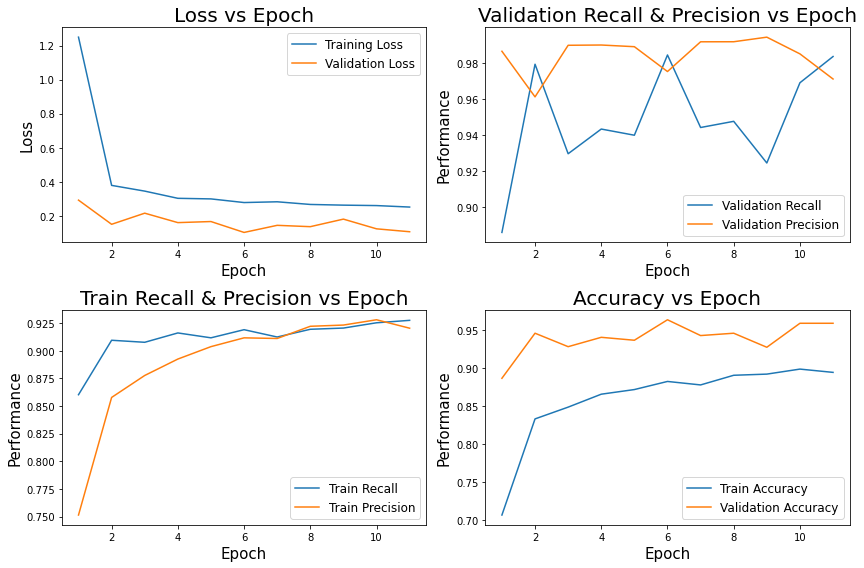

In [16]:
from functions import view_history

view_history(cnn, 'Version1')

In [17]:
from functions import model_evaluate

model_evaluate(cnn_1, train_gen, test_gen, val_gen)

41/41 [==============================] - 14s 345ms/step - loss: 0.1072 - precision: 0.9712 - recall: 0.9837 - accuracy: 0.9592


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.265685,87.665784,97.241634,88.637519
1,Test,0.435165,79.545456,98.717946,83.333331
2,Validation,0.107166,97.116202,98.367697,95.916796


The losses are noisy again but now we are capturing much more information with Convolutional layers that we are no longer obtaining perfect Recall on the test or Validation. Our Precision also went up by 10% which is really good. We need to deal with getting rid of some noise by increasing l2 regularizon by a small amount

# CNN Version 2

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from functions import get_optimizer

# Define input shape
input_shape = (150, 150, 3)

# Define the CNN model
model_cnn_2 = Sequential()

# Convolutional layers with MaxPooling
model_cnn_2.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model_cnn_2.add(MaxPooling2D((2, 2)))
model_cnn_2.add(Conv2D(64, (3, 3), activation='relu'))
model_cnn_2.add(MaxPooling2D((2, 2)))

# Flatten layer to transition from convolutional to dense layers
model_cnn_2.add(Flatten())

# Dense layers with Dropout and Regularizer
model_cnn_2.add(Dense(128, activation='relu', kernel_regularizer=l2(0.05)))
model_cnn_2.add(Dropout(0.2))
model_cnn_2.add(Dense(64, activation='relu', kernel_regularizer=l2(0.05)))
model_cnn_2.add(Dropout(0.2))
model_cnn_2.add(Dense(16, activation='relu', kernel_regularizer=l2(0.05)))
model_cnn_2.add(Dropout(0.2))

# Output layer
model_cnn_2.add(Dense(1, activation='sigmoid'))

# Compile the model
model_cnn_2.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=METRICS)
print(model_cnn_2.summary())


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 82944)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               10616960  
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)              

In [11]:
from functions import train_model
cnn = {}
cnn['Version2'] = train_model(model_cnn_2, train_gen, val_gen, 40)

Epoch 1/40
  1/163 [..............................] - ETA: 0s - loss: 19.0816 - precision: 0.0000e+00 - recall: 0.0000e+00 - accuracy: 0.3125WARNING:tensorflow:From c:\Users\delga\anaconda3\envs\flatiron2\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
163/163 [==============================] - 75s 461ms/step - loss: 3.2268 - precision: 0.7446 - recall: 0.9592 - accuracy: 0.7253 - val_loss: 1.3708 - val_precision: 0.5000 - val_recall: 1.0000 - val_accuracy: 0.5000
Epoch 2/40
163/163 [==============================] - 73s 446ms/step - loss: 0.7949 - precision: 0.7429 - recall: 1.0000 - accuracy: 0.7429 - val_loss: 0.8628 - val_precision: 0.5000 - val_recall: 1.0000 - val_accuracy: 0.5000
Epoch 3/40
163/163 [==============================] - 75s 460ms/step - loss: 0.6160 - precision: 0.7429 - recall: 1.000

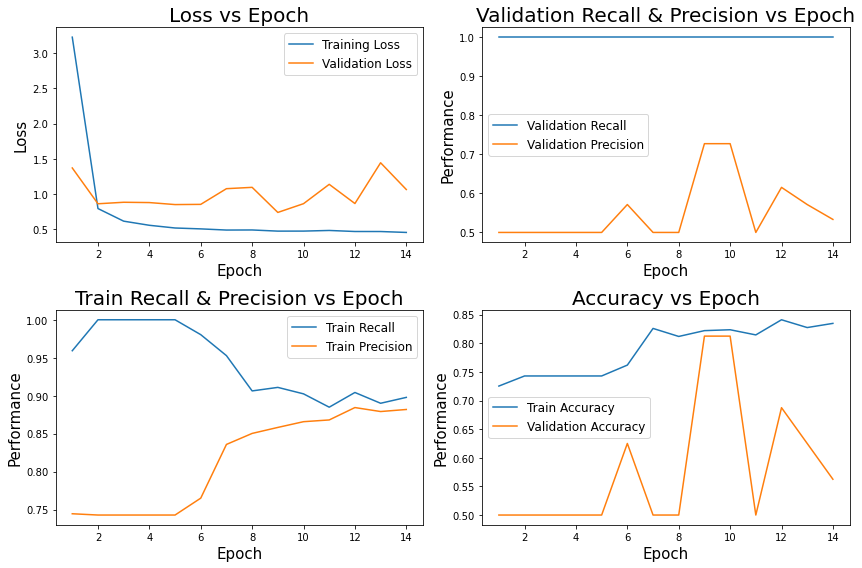

In [12]:
from functions import view_history

view_history(cnn, 'Version2')

In [13]:
from functions import model_evaluate

model_evaluate(model_cnn_2, train_gen, test_gen, val_gen)

1/1 [==============================] - 0s 1ms/step - loss: 1.0651 - precision: 0.5333 - recall: 1.0000 - accuracy: 0.5625


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.393925,84.821022,96.619356,84.643406
1,Test,0.560198,75.494069,97.948718,78.846157
2,Validation,1.065053,53.333336,100.000000,56.250000


It seems adding more regularization impacted our model in a bad way. We have more loss which makes sense because we have the same amount of layers with no extra neurons. Lets keep the regularization and add more ConV and Dense layers. 

# CNN Version 3

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from functions import get_optimizer

# Define input shape
input_shape = (150, 150, 3)

# Define the CNN model
model_cnn_3 = Sequential()

# Convolutional layers with MaxPooling
model_cnn_3.add(Conv2D(64, (3, 3), activation='relu', input_shape=input_shape))
model_cnn_3.add(MaxPooling2D((2, 2)))
model_cnn_3.add(Conv2D(64, (3, 3), activation='relu'))
model_cnn_3.add(MaxPooling2D((2, 2)))
model_cnn_3.add(Conv2D(64, (3, 3), activation='relu'))
model_cnn_3.add(MaxPooling2D((2, 2)))

# Flatten layer to transition from convolutional to dense layers
model_cnn_3.add(Flatten())

# Dense layers with Dropout and Regularizer
model_cnn_3.add(Dense(128, activation='relu', kernel_regularizer=l2(0.05)))
model_cnn_3.add(Dropout(0.2))
model_cnn_3.add(Dense(64, activation='relu', kernel_regularizer=l2(0.05)))
model_cnn_3.add(Dropout(0.2))
model_cnn_3.add(Dense(64, activation='relu', kernel_regularizer=l2(0.05)))
model_cnn_3.add(Dropout(0.2))
model_cnn_3.add(Dense(16, activation='relu', kernel_regularizer=l2(0.05)))
model_cnn_3.add(Dropout(0.2))

# Output layer
model_cnn_3.add(Dense(1, activation='sigmoid'))

# Compile the model
model_cnn_3.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=METRICS)
print(model_cnn_2.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 82944)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               10616960  
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)              

In [15]:
from functions import train_model

cnn['Version3'] = train_model(model_cnn_3, train_gen, val_gen, 40)

Epoch 1/40
163/163 [==============================] - 94s 577ms/step - loss: 4.3543 - precision: 0.7415 - recall: 0.9889 - accuracy: 0.7364 - val_loss: 1.4219 - val_precision: 0.5000 - val_recall: 1.0000 - val_accuracy: 0.5000
Epoch 2/40
163/163 [==============================] - 87s 535ms/step - loss: 0.8284 - precision: 0.7429 - recall: 1.0000 - accuracy: 0.7429 - val_loss: 0.8152 - val_precision: 0.5000 - val_recall: 1.0000 - val_accuracy: 0.5000
Epoch 3/40
163/163 [==============================] - 89s 549ms/step - loss: 0.6073 - precision: 0.7429 - recall: 1.0000 - accuracy: 0.7429 - val_loss: 0.7894 - val_precision: 0.5000 - val_recall: 1.0000 - val_accuracy: 0.5000
Epoch 4/40
163/163 [==============================] - 89s 549ms/step - loss: 0.5833 - precision: 0.7429 - recall: 1.0000 - accuracy: 0.7429 - val_loss: 0.7892 - val_precision: 0.5000 - val_recall: 1.0000 - val_accuracy: 0.5000
Epoch 5/40
163/163 [==============================] - 89s 548ms/step - loss: 0.5822 - precis

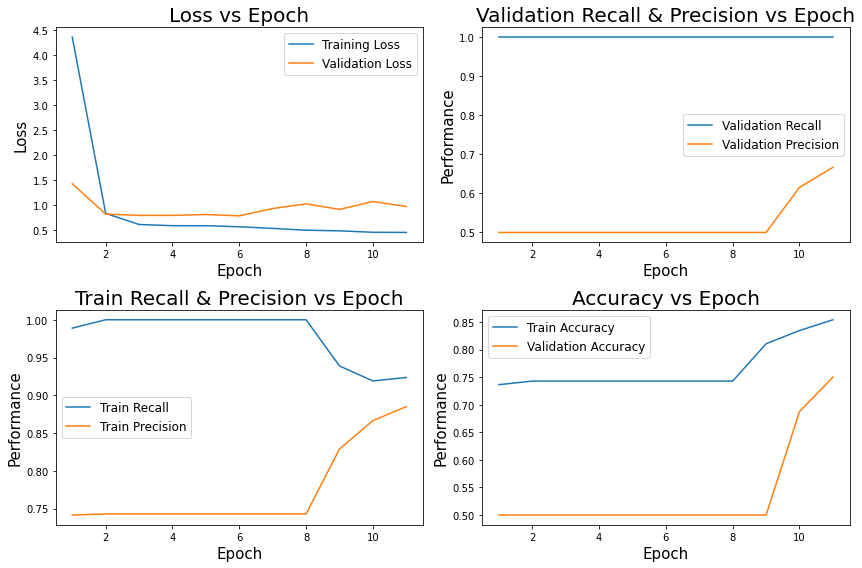

In [16]:
from functions import view_history

view_history(cnn, 'Version3')

In [17]:
from functions import model_evaluate

model_evaluate(model_cnn_3, train_gen, test_gen, val_gen)

1/1 [==============================] - 0s 1ms/step - loss: 0.9669 - precision: 0.6667 - recall: 1.0000 - accuracy: 0.7500


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.431116,88.425368,94.632256,86.809814
1,Test,0.566635,78.601694,95.128202,80.769229
2,Validation,0.966899,66.666669,100.000000,75.000000


It seems our noise is not an issue anymore because we added more infortmation to learn from. Lets add two dense layers and see the impact

# CNN Version 4

In [18]:
# Define input shape
input_shape = (150, 150, 3)

# Define the CNN model
model_cnn_4 = Sequential()

# Convolutional layers with MaxPooling
model_cnn_4.add(Conv2D(64, (3, 3), activation='relu', input_shape=input_shape))
model_cnn_4.add(MaxPooling2D((2, 2)))
model_cnn_4.add(Conv2D(64, (3, 3), activation='relu'))
model_cnn_4.add(MaxPooling2D((2, 2)))
model_cnn_4.add(Conv2D(64, (3, 3), activation='relu'))
model_cnn_4.add(MaxPooling2D((2, 2)))

# Flatten layer to transition from convolutional to dense layers
model_cnn_4.add(Flatten())

# Dense layers with Dropout and Regularizer
model_cnn_4.add(Dense(128, activation='relu', kernel_regularizer=l2(0.05)))
model_cnn_4.add(Dropout(0.2))
model_cnn_4.add(Dense(64, activation='relu', kernel_regularizer=l2(0.05)))
model_cnn_4.add(Dropout(0.2))
model_cnn_4.add(Dense(64, activation='relu', kernel_regularizer=l2(0.05)))
model_cnn_4.add(Dropout(0.2))
model_cnn_4.add(Dense(64, activation='relu', kernel_regularizer=l2(0.05)))
model_cnn_4.add(Dropout(0.2))
model_cnn_4.add(Dense(16, activation='relu', kernel_regularizer=l2(0.05)))
model_cnn_4.add(Dropout(0.2))

# Output layer
model_cnn_4.add(Dense(1, activation='sigmoid'))

# Compile the model
model_cnn_4.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=METRICS)
print(model_cnn_2.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 82944)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               10616960  
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)              

In [19]:
from functions import train_model

cnn['Version4'] = train_model(model_cnn_4, train_gen, val_gen, 40)

Epoch 1/40
163/163 [==============================] - 92s 564ms/step - loss: 5.7387 - precision: 0.7424 - recall: 0.9848 - accuracy: 0.7350 - val_loss: 1.8222 - val_precision: 0.5000 - val_recall: 1.0000 - val_accuracy: 0.5000
Epoch 2/40
163/163 [==============================] - 88s 538ms/step - loss: 0.9410 - precision: 0.7429 - recall: 1.0000 - accuracy: 0.7429 - val_loss: 0.8819 - val_precision: 0.5000 - val_recall: 1.0000 - val_accuracy: 0.5000
Epoch 3/40
163/163 [==============================] - 90s 551ms/step - loss: 0.6105 - precision: 0.7429 - recall: 1.0000 - accuracy: 0.7429 - val_loss: 0.8538 - val_precision: 0.5000 - val_recall: 1.0000 - val_accuracy: 0.5000
Epoch 4/40
163/163 [==============================] - 90s 552ms/step - loss: 0.5899 - precision: 0.7429 - recall: 1.0000 - accuracy: 0.7429 - val_loss: 0.7911 - val_precision: 0.5000 - val_recall: 1.0000 - val_accuracy: 0.5000
Epoch 5/40
163/163 [==============================] - 89s 547ms/step - loss: 0.5943 - precis

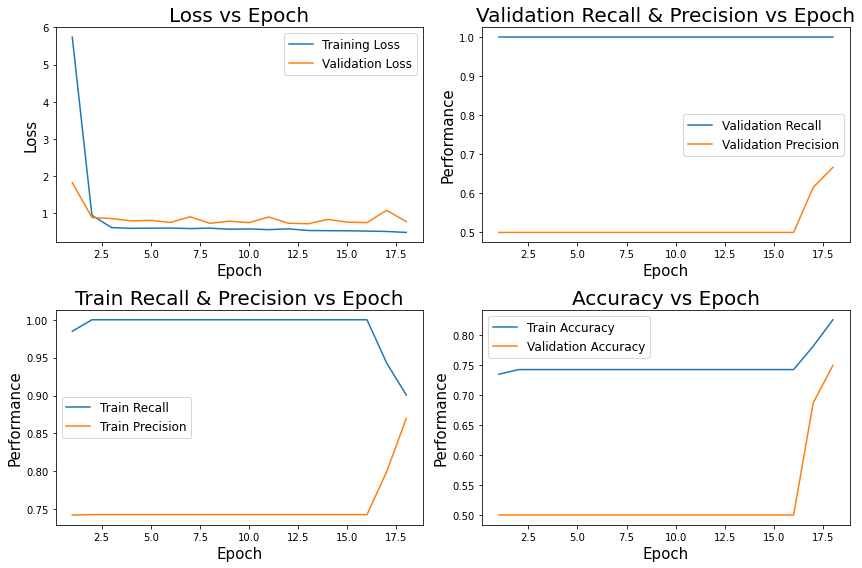

In [20]:
from functions import view_history

view_history(cnn, 'Version4')

In [21]:
from functions import model_evaluate

model_evaluate(model_cnn_4, train_gen, test_gen, val_gen)

1/1 [==============================] - 0s 998us/step - loss: 0.7699 - precision: 0.6667 - recall: 1.0000 - accuracy: 0.7500


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.425375,93.755275,86.012906,85.352761
1,Test,0.566209,83.292383,86.923075,80.929488
2,Validation,0.769917,66.666669,100.000000,75.000000


It seems that we are overfitting mainly because our val loss and train loss seem to mirror eachother. The model might be too complex. Instead lets reduce layers and only adjust the dropout. 

# CNN Version 5

In [22]:
from tensorflow.keras.layers import BatchNormalization

model_cnn_5 = Sequential()

# Convolutional layers with MaxPooling
model_cnn_5.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model_cnn_5.add(MaxPooling2D((2, 2)))
model_cnn_5.add(BatchNormalization())

model_cnn_5.add(Conv2D(64, (3, 3), activation='relu'))
model_cnn_5.add(MaxPooling2D((2, 2)))
model_cnn_5.add(BatchNormalization())

model_cnn_5.add(Conv2D(64, (3, 3), activation='relu'))
model_cnn_5.add(MaxPooling2D((2, 2)))
model_cnn_5.add(BatchNormalization())

# Flatten layer to transition from convolutional to dense layers
model_cnn_5.add(Flatten())

# Dense layers with Dropout and Regularizer
model_cnn_5.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
model_cnn_5.add(Dropout(0.5))
model_cnn_5.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model_cnn_5.add(Dropout(0.5))
model_cnn_5.add(Dense(16, activation='relu', kernel_regularizer=l2(0.01)))
model_cnn_5.add(Dropout(0.5))

# Output layer
model_cnn_5.add(Dense(1, activation='sigmoid'))

# Compile the model
model_cnn_5.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=METRICS)
print(model_cnn_5.summary())


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 74, 74, 32)        128       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 36, 36, 64)        256       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 34, 34, 64)       

Epoch 1/40
163/163 [==============================] - 82s 502ms/step - loss: 4.3110 - precision: 0.7902 - recall: 0.8346 - accuracy: 0.7101 - val_loss: 8.4558 - val_precision: 0.5000 - val_recall: 1.0000 - val_accuracy: 0.5000
Epoch 2/40
163/163 [==============================] - 75s 463ms/step - loss: 2.2592 - precision: 0.7765 - recall: 0.9324 - accuracy: 0.7504 - val_loss: 7.0742 - val_precision: 0.5000 - val_recall: 1.0000 - val_accuracy: 0.5000
Epoch 3/40
163/163 [==============================] - 77s 475ms/step - loss: 1.4171 - precision: 0.8348 - recall: 0.9221 - accuracy: 0.8066 - val_loss: 2.7834 - val_precision: 0.5000 - val_recall: 1.0000 - val_accuracy: 0.5000
Epoch 4/40
163/163 [==============================] - 78s 479ms/step - loss: 1.1269 - precision: 0.8542 - recall: 0.9285 - accuracy: 0.8292 - val_loss: 4.7137 - val_precision: 0.5000 - val_recall: 1.0000 - val_accuracy: 0.5000
Epoch 5/40
163/163 [==============================] - 78s 477ms/step - loss: 0.9092 - precis

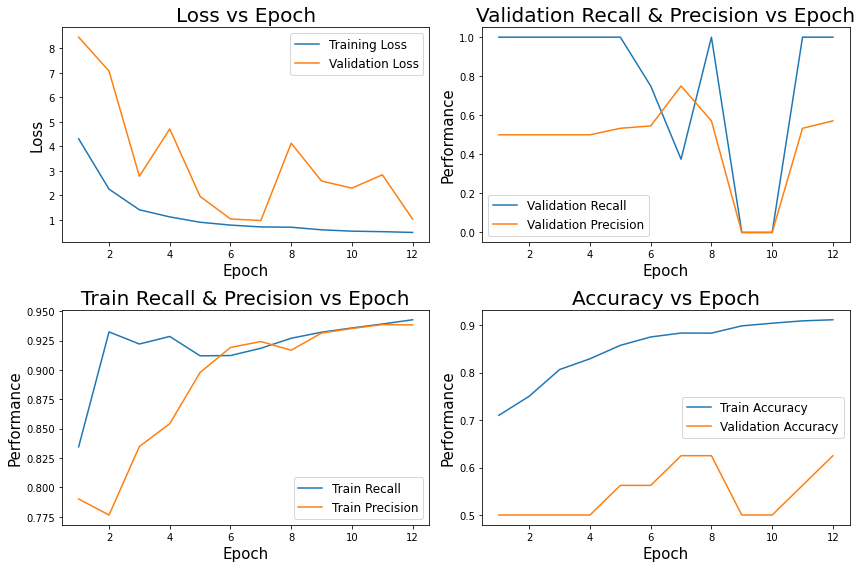

1/1 [==============================] - 0s 3ms/step - loss: 1.0336 - precision: 0.5714 - recall: 1.0000 - accuracy: 0.6250


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.428657,93.703151,96.774191,92.772239
1,Test,0.591830,86.013985,94.615382,87.019229
2,Validation,1.033625,57.142860,100.000000,62.500000


In [24]:
from functions import model_evaluate, view_history, train_model

cnn['Version5'] = train_model(model_cnn_5, train_gen, val_gen, 40)
view_history(cnn, 'Version5')
model_evaluate(model_cnn_5, train_gen, test_gen, val_gen)

It seems no matter how much we try we get noisy results. Lets attempt to increase the images by doing data augmentation. Currently the train gen only zooms and flips images. Lets introduce more image types. 

# Data Augmentation CNN

Lets use Version 4 CNN where we did overfit slighlt but maybe the data augmentation will help this ovefit

In [13]:
# Generate our new test, train, val data
from functions import data_augmentation

img_dims = 150

# test and val are not actually augmented just training
train_gen_aug, test_gen_aug, val_gen_aug = data_augmentation(150, 32, train_data_dir, test_data_dir, val_data_dir)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Define input shape
input_shape = (150, 150, 3)

# Define the CNN model
cnn_aug1 = Sequential()

# Convolutional layers with MaxPooling
cnn_aug1.add(Conv2D(64, (3, 3), activation='relu', input_shape=input_shape))
cnn_aug1.add(MaxPooling2D((2, 2)))
cnn_aug1.add(Conv2D(64, (3, 3), activation='relu'))
cnn_aug1.add(MaxPooling2D((2, 2)))
cnn_aug1.add(Conv2D(64, (3, 3), activation='relu'))
cnn_aug1.add(MaxPooling2D((2, 2)))

# Flatten layer to transition from convolutional to dense layers
cnn_aug1.add(Flatten())

# Dense layers with Dropout and Regularizer
cnn_aug1.add(Dense(128, activation='relu', kernel_regularizer=l2(0.05)))
cnn_aug1.add(Dropout(0.2))
cnn_aug1.add(Dense(64, activation='relu', kernel_regularizer=l2(0.05)))
cnn_aug1.add(Dropout(0.2))
cnn_aug1.add(Dense(64, activation='relu', kernel_regularizer=l2(0.05)))
cnn_aug1.add(Dropout(0.2))
cnn_aug1.add(Dense(64, activation='relu', kernel_regularizer=l2(0.05)))
cnn_aug1.add(Dropout(0.2))
cnn_aug1.add(Dense(16, activation='relu', kernel_regularizer=l2(0.05)))
cnn_aug1.add(Dropout(0.2))

# Output layer
cnn_aug1.add(Dense(1, activation='sigmoid'))

# Compile the model
cnn_aug1.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=METRICS)
print(cnn_aug1.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18496)             0

Epoch 1/40
  1/163 [..............................] - ETA: 0s - loss: 25.1581 - precision: 0.7500 - recall: 0.7200 - accuracy: 0.5938WARNING:tensorflow:From c:\Users\delga\anaconda3\envs\flatiron2\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
163/163 [==============================] - 94s 577ms/step - loss: 5.4810 - precision: 0.7436 - recall: 0.9848 - accuracy: 0.7364 - val_loss: 1.6286 - val_precision: 0.5000 - val_recall: 1.0000 - val_accuracy: 0.5000
Epoch 2/40
163/163 [==============================] - 94s 576ms/step - loss: 0.8830 - precision: 0.7429 - recall: 1.0000 - accuracy: 0.7429 - val_loss: 0.8366 - val_precision: 0.5000 - val_recall: 1.0000 - val_accuracy: 0.5000
Epoch 3/40
163/163 [==============================] - 87s 536ms/step - loss: 0.5962 - precision: 0.7429 - recall: 1.0000 - accu

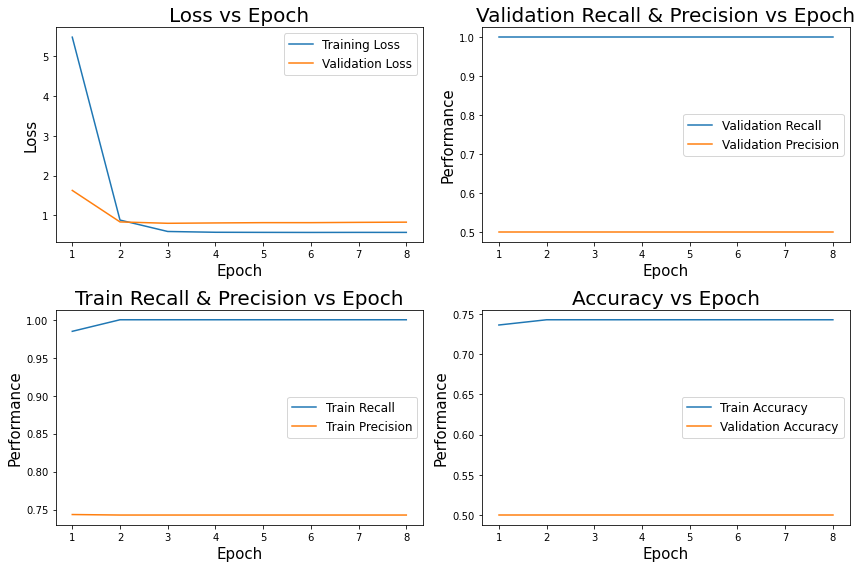

1/1 [==============================] - 0s 1ms/step - loss: 0.8306 - precision: 0.5000 - recall: 1.0000 - accuracy: 0.5000


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.570093,74.290645,100.0,74.290645
1,Test,0.696533,62.500000,100.0,62.500000
2,Validation,0.830581,50.000000,100.0,50.000000


In [16]:
from functions import model_evaluate, train_model, view_history

CNN_Aug = {}

# Train and save history 
CNN_Aug['Version1'] = train_model(cnn_aug1, train_gen_aug, val_gen_aug, 40)

# Visualize model history 
view_history(CNN_Aug, 'Version1')

# Evaluate Model 
model_evaluate(cnn_aug1, train_gen_aug, test_gen_aug, val_gen_aug)